In [21]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

1. Reading the cascades BGS catalog

In [22]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
dataname = 'alltiles_BGS_ANYzinfo.fits'
catalog = Table.read(diretory+dataname,hdu='ZBEST')
#zmag = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']

2. Selecting the deep coadds with EFFTIME_dark>400

In [23]:
search_BGS = np.where((catalog['subset']=='deep')  & (catalog['EFFTIME_BRIGHT']>400))
catalog_BGS = catalog[search_BGS[0]].copy()
print('Number of deep coadds BGS:',len(search_BGS[0]))

Number of deep coadds BGS: 80604


3. Selecting the short exposures coadds with EFFTIME_dark>100 (not deep or all)

In [24]:
search_BGS_short = np.where((catalog['subset']!='all') & (catalog['subset']!='deep') & (catalog['EFFTIME_BRIGHT']>100))
catalog_BGS_short = catalog[search_BGS_short[0]].copy()
print('Number of short exposures:', len(catalog_BGS_short))

Number of short exposures: 1014339


Just checking the EFFTIME_BRIGHT distribution

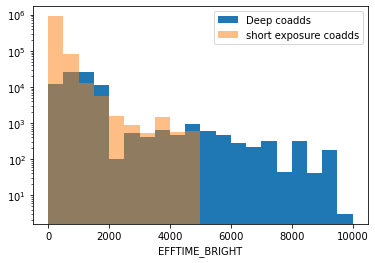

In [25]:
plt.hist(catalog_BGS['EFFTIME_BRIGHT'],bins=20,range=(0,10000),label='Deep coadds')
plt.hist(catalog_BGS_short['EFFTIME_BRIGHT'],bins=20,range=(0,10000),alpha=0.5,label='short exposure coadds')
plt.xlabel('EFFTIME_BRIGHT')
plt.yscale('log')
plt.legend()

4. Creating pandas tables from fit formats

In [26]:
new_catalog_BGS_short = catalog_BGS_short[['TARGETID','Z','subset','TILEID','EFFTIME_BRIGHT','DELTACHI2','ZWARN']].to_pandas()
new_catalog_BGS = catalog_BGS['TARGETID','Z','subset','TILEID','DELTACHI2','EFFTIME_BRIGHT','FIBERFLUX_R','FIBERFLUX_Z','EBV','ZWARN'].to_pandas()

5. Matching the two catalogs with targetid. The redrock information from the deep coadds has suffixes _deep and short coadds with _short

In [27]:
catalog_BGS_match = new_catalog_BGS.merge(new_catalog_BGS_short,on='TARGETID',how='left',suffixes=("_deep","_short"))

6. Removing same objects but observe in different tiles. and create redshift difference and zfibermag information

In [28]:
final_match_catalog = catalog_BGS_match[catalog_BGS_match['TILEID_deep']==catalog_BGS_match['TILEID_short']]
final_match_catalog['dz']=abs(final_match_catalog['Z_deep']-final_match_catalog['Z_short'])/(1.+final_match_catalog['Z_deep'])
final_match_catalog['zfibermag']=-2.5*np.log10(final_match_catalog['FIBERFLUX_Z'])+22.5-1.211*final_match_catalog['EBV']
final_match_catalog['rfibermag']=-2.5*np.log10(final_match_catalog['FIBERFLUX_R'])+22.5-2.165*final_match_catalog['EBV']

7. Selecting targets with non repeatable redshifts.


Selection:
    a. |z_deep-z_short|/(1+z_deep)>0.0033
    
    b. DELTACHI2_deep>15
    
    c. Z_deep<0.9
    
    d. DELTACHI2_short>10
    
    e. zfibermag<20.3
    
    f. ZWARN_deep<=4
    
    g. ZWARN_short<=4
    


In [40]:
dz_not_good_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & 
                                          (final_match_catalog['DELTACHI2_deep']>15) & 
                                          (final_match_catalog['Z_deep']<0.9) & 
                                          (final_match_catalog['DELTACHI2_short']>10) &
                                          (final_match_catalog['rfibermag']<=20.3) & 
                                          (final_match_catalog['ZWARN_deep']<=4) & 
                                          (final_match_catalog['ZWARN_short']<=4)]

8. Looking at the DELTACHI2_deep distribution with non-repeatable redshifts. What is interesting is that  there are many objects with high Deltachi2 but non-repeatable redshifts.

(1.0, 5.0)

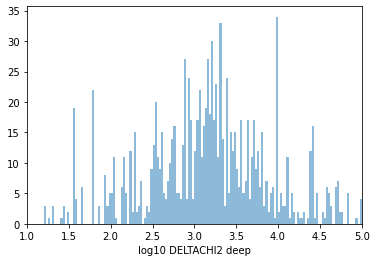

In [41]:
plt.hist(np.log10(dz_not_good_catalog['DELTACHI2_deep']),bins=200,range=(0,5),alpha=0.5)
plt.xlabel('log10 DELTACHI2 deep')
plt.xlim(1,5)
#plt.axvline(2.55)
#plt.axvline(2.525)

In [42]:
#dz_not_good_catalog[(np.log10(dz_not_good_catalog['DELTACHI2_deep'])>2.525) & (np.log10(dz_not_good_catalog['DELTACHI2_deep'])<2.55)]

In [43]:
print('Number of unique targets in the selection:',len(set(dz_not_good_catalog['TARGETID'])))

Number of unique targets in the selection: 564


In [44]:
dz_not_good_catalog

,TARGETID,Z_deep,subset_deep,TILEID_deep,DELTACHI2_deep,EFFTIME_BRIGHT_deep,FIBERFLUX_R,FIBERFLUX_Z,EBV,ZWARN_deep,Z_short,subset_short,TILEID_short,EFFTIME_BRIGHT_short,DELTACHI2_short,ZWARN_short,dz,zfibermag,rfibermag
1866,39627222650196713,0.306351,b'deep',80674,1779.480305,2775.008194,8.058004,16.948225,0.027687,0,0.391501,b'20210109',80674,807.210037,120.497871,0,0.065181,19.393660,20.174490
1867,39627222650196713,0.306351,b'deep',80674,1779.480305,2775.008194,8.058004,16.948225,0.027687,0,0.982008,b'20210116',80674,408.062119,87.259342,0,0.517209,19.393660,20.174490
1868,39627222650196713,0.306351,b'deep',80674,1779.480305,2775.008194,8.058004,16.948225,0.027687,0,0.391826,b'20210105',80674,374.864014,117.655208,0,0.065430,19.393660,20.174490
1869,39627222650196713,0.306351,b'deep',80674,1779.480305,2775.008194,8.058004,16.948225,0.027687,0,0.391858,b'20210106',80674,487.999817,38.713246,0,0.065455,19.393660,20.174490
1873,39627222650196713,0.306351,b'deep',80674,1779.480305,2775.008194,8.058004,16.948225,0.027687,0,0.977279,b'00072684',80674,124.459465,46.557366,0,0.513589,19.393660,20.174490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825183,39633567696815733,0.284010,b'deep',80694,5232.447023,3862.463150,7.097050,18.265144,0.224691,0,1.675282,b'00071480',80694,164.184677,26.589900,0,1.083537,19.073841,19.885849
825187,39633567696815733,0.284010,b'deep',80694,5232.447023,3862.463150,7.097050,18.265144,0.224691,0,1.687326,b'00072705',80694,202.887772,30.545552,0,1.092917,19.073841,19.885849
825191,39633567696815733,0.284010,b'deep',80694,5232.447023,3862.463150,7.097050,18.265144,0.224691,0,0.491402,b'00071478',80694,273.753204,112.272536,0,0.161519,19.073841,19.885849
825192,39633567696815733,0.284010,b'deep',80694,5232.447023,3862.463150,7.097050,18.265144,0.224691,0,1.680830,b'00070967',80694,336.326477,35.975824,0,1.087858,19.073841,19.885849


9. Another selection

a. DELTACHI2_deep>15

b. Z_deep>0.9

c. rfibermag<20.3

In [45]:
new_catalog_BGS['rfibermag']=-2.5*np.log10(new_catalog_BGS['FIBERFLUX_R'])+22.5-2.165*new_catalog_BGS['EBV']
high_z_strange_object = new_catalog_BGS[(new_catalog_BGS['DELTACHI2']>15) & (new_catalog_BGS['Z']>0.9) & (new_catalog_BGS['rfibermag']<20.3)]
print(len(high_z_strange_object))

162


10. Combining the two catalogs and producing a list with 
TILEID, TARGETID, ID_FOR_selection

In [46]:
all_tileid = np.append(dz_not_good_catalog['TILEID_deep'].to_numpy(),high_z_strange_object['TILEID'].to_numpy())
all_targetid = np.append(dz_not_good_catalog['TARGETID'].to_numpy(),high_z_strange_object['TARGETID'].to_numpy())
all_VI_selection = np.append(np.arange(0,len(dz_not_good_catalog['TARGETID'].to_numpy()))*0.,
                             np.arange(0,len(high_z_strange_object['TARGETID'].to_numpy()))*0.+1)

11. Creating an unique target list with no repetition 

In [47]:
TILEID = []
FINAL_TARGETID = []
FINAL_selection = []
unique_tileid = np.array(list(set(all_tileid)))
Number_of_object_per_tile = {}
for i_tile in range(0,len(unique_tileid)):
    search = np.where(all_tileid==unique_tileid[i_tile])
    tmp_targetid = all_targetid[search[0]]
    
    unique_targetid = np.array(list(set(tmp_targetid)))
    Number_of_object_per_tile[unique_tileid[i_tile]]=len(unique_targetid)
    for i_td in range(0,len(unique_targetid)):
        TILEID.append(unique_tileid[i_tile])
        FINAL_TARGETID.append(unique_targetid[i_td])
        search_selection = np.where((all_tileid==unique_tileid[i_tile]) & (all_targetid==unique_targetid[i_td]))
        FINAL_selection.append(int(all_VI_selection[search_selection[0][0]]))

In [48]:
print(len(FINAL_selection))
Number_of_object_per_tile

727


{80641: 50,
 80642: 41,
 80643: 65,
 80644: 10,
 80645: 17,
 80646: 36,
 80647: 12,
 80649: 14,
 80650: 30,
 80651: 8,
 80653: 49,
 80654: 71,
 80655: 25,
 80656: 17,
 80660: 29,
 80663: 5,
 80664: 46,
 80669: 1,
 80670: 20,
 80674: 3,
 80675: 1,
 80676: 1,
 80678: 4,
 80680: 2,
 80682: 1,
 80685: 1,
 80688: 1,
 80690: 6,
 80692: 1,
 80693: 1,
 80694: 9,
 80700: 3,
 80701: 1,
 80707: 3,
 80711: 2,
 80722: 1,
 80605: 2,
 80607: 1,
 80609: 1,
 80738: 1,
 80611: 8,
 80612: 3,
 80613: 20,
 80614: 2,
 80616: 50,
 80617: 6,
 80618: 17,
 80619: 7,
 80620: 1,
 80622: 2,
 80624: 6,
 80628: 4,
 80629: 8,
 80632: 1}

In [49]:
d = {'TILEID':TILEID,'TARGETID':FINAL_TARGETID,'VI_selection':FINAL_selection}
df = pd.DataFrame(data=d)

In [178]:
df.to_csv('SV_cascades_BGS_VI_target_list.v05.csv',index=False)

In [179]:
new_data = pd.read_csv('SV_cascades_BGS_VI_target_list.v05.csv')

In [180]:
print('TOTAL selected spectra for VI:',len(TILEID))

TOTAL selected spectra for VI: 2318
